In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt
import itertools as it
from new_analysis_utils import *
from statannot import add_stat_annotation

%load_ext rpy2.ipython
sns.set_style('whitegrid')

In [4]:
sns.set_style('whitegrid')  # why does this need to be run twice?!

# Setup

In [5]:
EXPERIMENT = 5
figs = Figures(path=f'figs/{EXPERIMENT}')
figure = figs.plot
fb_order = ['none', 'action', 'meta', 'video']

def write_tex(name, tex):
    file = f"stats/{EXPERIMENT}/{name}.tex"
    with open(file, "w+") as f:
        f.write(str(tex) + r"\unskip")
    print(f'wrote "{tex}" to "{file}"')

def write_percent(name, x):
    write_tex(name, f'{x * 100:.1f}\\%')

def read(stage, name):
    loader = pd.read_csv if name.endswith('csv') else pd.read_json
    df = loader(f'../data/{EXPERIMENT}/stage{stage}/{name}')
    df = drop_nan_cols(df).set_index('wid')
    parse_json(df)
    return df

participants = read(1, 'participants.csv').rename(columns={'completed': 'completed_stage1'})
survey = read(1, 'survey.csv')
stage1 = read(1, 'trials.csv')
stage2 = read(2, 'trials.json')
bonus = read(2, 'bonus.csv').bonus

# Drop participants who didn't finish both sections
# Note: they are still in the participants dataframe for computing retention rates
participants['completed_stage2'] = (stage2.reset_index().wid.value_counts() == 8)
participants.completed_stage2 = participants.completed_stage2.fillna(False)
pdf = participants.query('completed_stage2').copy()
keep = list(pdf.index)
stage1 = stage1.query('wid == @keep').copy()
stage2 = stage2.query('wid == @keep').copy()

# stage2['planning_cost'] = stage2.planning_time / 4000
# recomputed_bonus = (420 - (stage2.planning_cost + stage2.route_cost)).clip(0) / 2000

stage2['planning_cost'] = stage2.planning_time / 4000
# recomputed_bonus = (350 - (stage2.planning_cost + stage2.route_cost)).clip(0) / 1000

# error = abs(recomputed_bonus - stage2.bonus)
# assert error.mean() < .001
# assert error.max() < .05 # one bad trial

stage1['feedback'] = pdf.feedback
stage2['feedback'] = pdf.feedback
stage2['score'] = stage2.bonus * 2000
stage2['n_click'] = stage2.reveals.apply(len)

# Normalize scores
with open('mouselab_maxscores.json') as f:
    stage1_hi = json.load(f)["basic"]

stage1.score *= (100/stage1_hi)

with open('roadtrip_scores.json') as f:
    x = json.load(f)
    lo = {k: v[0] for k, v in x.items()}
    hi = {k: v[1] for k, v in x.items()}

lo2 = stage2.map.apply(lo.get)
hi2 = stage2.map.apply(hi.get)

stage2.score = 100 * (stage2.score - lo2) / (hi2 - lo2)

pdf['bonus'] = bonus
pdf['stage1_n_click'] = stage1.groupby('wid').n_clicks.mean()
pdf['stage2_n_click'] = stage2.groupby('wid').n_click.mean()
pdf['route_cost'] = stage2.groupby('wid').route_cost.mean()
pdf['planning_cost'] = stage2.groupby('wid').planning_cost.mean()

pdf['score'] = stage2.groupby('wid').score.mean()
pdf['early_score'] = stage2.query('trial_index < 4').groupby('wid').score.mean()

nice_names['route_cost'] = 'Route Cost'

In [6]:
print(pdf.previously_participated.value_counts())
write_tex('N-drop-previous', sum(pdf.previously_participated != "No"))
pdf = pdf.query('previously_participated == "No"')
keep = list(pdf.index)
stage1 = stage1.query('wid == @keep')
stage2 = stage2.query('wid == @keep')
# assert set(stage2.index) == set(stage1.index) == set(pdf.index)

No          963
Yes         101
Not sure      8
Name: previously_participated, dtype: int64
wrote "112" to "stats/5/N-drop-previous.tex"


In [5]:
from statsmodels.formula.api import ols
mod = ols('planning_cost ~ n_click', data=stage2).fit()
mod.params
# sns.lineplot('n_click', 'planning_cost', data=stage2)

Intercept    3.948432
n_click      1.975974
dtype: float64

In [6]:
pdf.groupby('feedback').score.mean()

feedback
action    48.810823
meta      52.171093
none      43.910311
video     42.384130
Name: score, dtype: float64

# Demographics

In [1]:
def regularize_gender(s):
    d = {
        'man': 'male',
        'woman': 'female',
        'f': 'female',
        'm': 'male',
    }
    s = s.lower().strip()
    return d.get(s, s)

gender = pdf.sex.str.lower()  # not very woke, but this is what Prolific gives us.
age = pdf.age.apply(excepts(ValueError, int, lambda _: None))
age.loc[age < 18] = None

n_gen = gender.apply(lambda x: x in ('male', 'female')).sum()
write_tex("N-gender", f'${n_gen}$')
n_age = (~age.isna()).sum()
write_tex("N-age", f'$n_age$')
    
write_tex('mean-age', f'${age.mean():.1f}$')
write_tex('min-age', f'${age.min():.0f}$')
write_tex('max-age', f'${age.max():.0f}$')

regularize = {
    'man': 'male',
    'woman': 'female',
    'f': 'female',
    'm': 'male',
}
gender = gender.apply(lambda x: regularize.get(x.strip(), x))
n_fem = gender.value_counts()['female']
write_tex("N-female", f'${n_fem}$')

write_tex("N-total", f"${len(pdf)}$")
for fb, n in pdf.feedback.value_counts().items():
    write_tex(f"N-{fb}", f"${n}$")
    
write_tex('mean-bonus', f'\${pdf.bonus.mean():.2f}')

NameError: name 'pdf' is not defined

In [8]:
N = participants.query('completed_stage1').groupby(['completed_stage2', 'feedback']).apply(len)

for fb in fb_order:
    write_tex(f'N-drop-{fb}', N[False, fb])
    write_percent(f'drop-rate-{fb}', N[False, fb] / N[:, fb].sum())
write_percent('drop-rate', N[False].sum() / N.sum())
write_tex('return-N', N[True].sum())

wrote "44" to "stats/5/N-drop-none.tex"
wrote "13.9\%" to "stats/5/drop-rate-none.tex"
wrote "41" to "stats/5/N-drop-action.tex"
wrote "13.4\%" to "stats/5/drop-rate-action.tex"
wrote "36" to "stats/5/N-drop-meta.tex"
wrote "11.7\%" to "stats/5/drop-rate-meta.tex"
wrote "42" to "stats/5/N-drop-video.tex"
wrote "13.7\%" to "stats/5/drop-rate-video.tex"
wrote "13.2\%" to "stats/5/drop-rate.tex"
wrote "1074" to "stats/5/return-N.tex"


# Transfer performance

In [9]:
N_BOOT = 10000

def ci(xs):
    return np.quantile(xs, [0.025, 0.975])

def boot_means(X, n=N_BOOT):
    r = {}
    for fb in fb_order:
        x = X.loc[fb]
        means = [x.sample(frac=1, replace=True).mean() for _ in range(n)]
        r[fb] = np.array(means)
    return r

def write_means(var, units='points'):
    X = pdf.set_index('feedback')[var]
    bm = boot_means(X)
    for fb in fb_order:
        x = X.loc[fb].mean()
        a, b = ci(bm[fb])
        write_tex(f'{var}-mean-{fb}', rf'${x:.2f}$ {units}; 95\% CI: [${a:.2f}$, ${b:.2f}$]')
        write_tex(f'{var}-mean-{fb}-alt', rf'${x:.2f}$ {units} (95\% CI: [${a:.2f}$, ${b:.2f}$])')

In [10]:
!pip install statannot

In [11]:
def write_kruskal(name):
    out = %R kruskal.test($name ~ feedback, data=rdf)
    out = dict(out.items())
    df = out["parameter"][0]
    p = pval(out["p.value"][0])
    stat = out["statistic"][0]
    write_tex(f'{name}-kruskal', rf'$H = {stat:.2f}, {p}$')

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std =  np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

import re
independence_results = {}
def write_independence_test(y, a, b, alternative='greater'):
    # oddly, feedback == b tests a > b
    out = %R independence_test($y ~ feedback == "$b",\
                               data=filter(rdf, feedback %in% c("$a", "$b")),\
                               alternative="$alternative")
    out = str(out)
    match = re.search('Z = (.*), p-value = (.*)', out)
    try:
        z, p = map(float, match.groups())
    except:
        print('Cannot parse independence test')
        print(out)
        raise Exception()
    
    x = pdf.set_index('feedback')[y]
    d = cohen_d(x.loc[a], x.loc[b])
    write_tex(f'independence-{y}-{a}-{b}', f'$d = {d:.2f}, Z = {z:.2f}, {pval(p)}$')
    independence_results[(y, a, b)] = p

def write_comparisons(y, **kws):
    for fb in ['none', 'action', 'video']:
        write_independence_test(y, 'meta', fb, **kws)
    
    for fb in ['none', 'action']:
        write_independence_test(y, fb, 'video', **kws)

rdf = pdf[['feedback', 'bonus', 'score', 'early_score', 'route_cost', 'stage2_n_click', 'planning_cost']]

In [12]:
%%R -i rdf
library(dplyr)
library(coin)
rdf$feedback = relevel(factor(rdf$feedback), ref="video")

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: survival



## Total Score

In [13]:
write_kruskal('score')

wrote "$H = 8.87, p = .031$" to "stats/5/score-kruskal.tex"


In [14]:
write_comparisons('score')

wrote "$d = 0.18, Z = 2.00, p = .023$" to "stats/5/independence-score-meta-none.tex"
wrote "$d = 0.08, Z = 0.84, p = .202$" to "stats/5/independence-score-meta-action.tex"
wrote "$d = 0.23, Z = 2.56, p = .005$" to "stats/5/independence-score-meta-video.tex"
wrote "$d = 0.04, Z = 0.39, p = .348$" to "stats/5/independence-score-none-video.tex"
wrote "$d = 0.15, Z = 1.68, p = .046$" to "stats/5/independence-score-action-video.tex"


In [15]:
write_comparisons('early_score')

wrote "$d = 0.18, Z = 1.97, p = .024$" to "stats/5/independence-early_score-meta-none.tex"
wrote "$d = 0.08, Z = 0.87, p = .192$" to "stats/5/independence-early_score-meta-action.tex"
wrote "$d = 0.24, Z = 2.66, p = .004$" to "stats/5/independence-early_score-meta-video.tex"
wrote "$d = 0.05, Z = 0.55, p = .290$" to "stats/5/independence-early_score-none-video.tex"
wrote "$d = 0.16, Z = 1.79, p = .037$" to "stats/5/independence-early_score-action-video.tex"


[0.02257, 0.005284, 0.04639]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

meta v.s. video: Custom statistical test, P_val:5.284e-03
none v.s. meta: Custom statistical test, P_val:2.257e-02
action v.s. video: Custom statistical test, P_val:4.639e-02
figs/5/transfer_score.pdf
figs/5/transfer_score_dist.pdf


<function new_analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

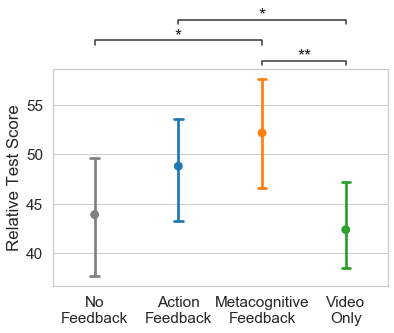

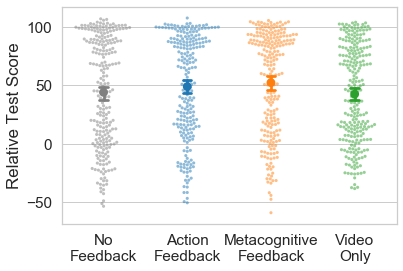

In [17]:
def plot_transfer(outcome, flag=''):
    plt.figure()
#     plt.axhline(315.956, color='k', ls='--', alpha=0.7)
    if flag == 'dist':
        sns.swarmplot('feedback', outcome, data=pdf, palette=palette, alpha=0.5, order=fb_order, 
                  size=3.1)

    sns.pointplot('feedback', outcome, data=pdf, palette=palette, order=fb_order, 
                  scale=1, capsize=0.1, markers='o', n_boot=100)
    plt.ylabel(nice_names[outcome])
    plt.xlabel('')
    # test = 'Test' if EXPERIMENT == 1 else 'Transfer'
    reformat_labels()
    plt.ylabel('Relative Test Score')
    
    if flag != 'dist':
        all_pairs = [('meta', 'none'), ('meta', 'action'), ('meta', 'video'), 
                     ('none', 'video'), ('action', 'video'),]
        pairs = [(f1, f2) for (f1, f2) in all_pairs if independence_results['score', f1, f2] < .05]
        p = [independence_results[outcome, f1, f2] for (f1, f2) in pairs]
        print(p)
        p = [max(p, .001) for p in p] # at most 3 stars
        add_stat_annotation(plt.gca(), data=pdf, x='feedback', y=outcome, order=fb_order,
            box_pairs=pairs,
            pvalues=p, text_format='star', 
            fontsize=18, loc='outside', perform_stat_test=False, 
            line_offset=.015, text_offset=-5
        )

figure(outcome='score')(plot_transfer)
figure(outcome='score', flag='dist')(plot_transfer)

In [18]:
write_means('score')

wrote "$43.91$ points; 95\% CI: [$38.08$, $49.78$]" to "stats/5/score-mean-none.tex"
wrote "$43.91$ points (95\% CI: [$38.08$, $49.78$])" to "stats/5/score-mean-none-alt.tex"
wrote "$48.81$ points; 95\% CI: [$43.26$, $54.37$]" to "stats/5/score-mean-action.tex"
wrote "$48.81$ points (95\% CI: [$43.26$, $54.37$])" to "stats/5/score-mean-action-alt.tex"
wrote "$52.17$ points; 95\% CI: [$46.58$, $57.67$]" to "stats/5/score-mean-meta.tex"
wrote "$52.17$ points (95\% CI: [$46.58$, $57.67$])" to "stats/5/score-mean-meta-alt.tex"
wrote "$42.38$ points; 95\% CI: [$37.40$, $47.43$]" to "stats/5/score-mean-video.tex"
wrote "$42.38$ points (95\% CI: [$37.40$, $47.43$])" to "stats/5/score-mean-video-alt.tex"


## Bonus

In [49]:
write_kruskal('bonus')

wrote "$H = 8.76, p = .033$" to "stats/5/bonus-kruskal.tex"


In [50]:
write_comparisons('bonus')

wrote "$d = 0.18, Z = 1.97, p = .024$" to "stats/5/independence-bonus-meta-none.tex"
wrote "$d = 0.07, Z = 0.74, p = .230$" to "stats/5/independence-bonus-meta-action.tex"
wrote "$d = 0.23, Z = 2.53, p = .006$" to "stats/5/independence-bonus-meta-video.tex"
wrote "$d = 0.04, Z = 0.41, p = .341$" to "stats/5/independence-bonus-none-video.tex"
wrote "$d = 0.16, Z = 1.76, p = .039$" to "stats/5/independence-bonus-action-video.tex"


In [51]:
write_comparisons('score')

wrote "$d = 0.18, Z = 2.00, p = .023$" to "stats/5/independence-score-meta-none.tex"
wrote "$d = 0.08, Z = 0.84, p = .202$" to "stats/5/independence-score-meta-action.tex"
wrote "$d = 0.23, Z = 2.56, p = .005$" to "stats/5/independence-score-meta-video.tex"
wrote "$d = 0.04, Z = 0.39, p = .348$" to "stats/5/independence-score-none-video.tex"
wrote "$d = 0.15, Z = 1.68, p = .046$" to "stats/5/independence-score-action-video.tex"


## Route cost

In [19]:
write_kruskal('route_cost')

wrote "$H = 6.81, p = .078$" to "stats/5/route_cost-kruskal.tex"


In [20]:
write_means('route_cost')

wrote "$574.18$ points; 95\% CI: [$564.00$, $584.22$]" to "stats/5/route_cost-mean-none.tex"
wrote "$574.18$ points (95\% CI: [$564.00$, $584.22$])" to "stats/5/route_cost-mean-none-alt.tex"
wrote "$564.58$ points; 95\% CI: [$555.05$, $574.49$]" to "stats/5/route_cost-mean-action.tex"
wrote "$564.58$ points (95\% CI: [$555.05$, $574.49$])" to "stats/5/route_cost-mean-action-alt.tex"
wrote "$558.65$ points; 95\% CI: [$549.14$, $568.07$]" to "stats/5/route_cost-mean-meta.tex"
wrote "$558.65$ points (95\% CI: [$549.14$, $568.07$])" to "stats/5/route_cost-mean-meta-alt.tex"
wrote "$573.97$ points; 95\% CI: [$565.14$, $583.12$]" to "stats/5/route_cost-mean-video.tex"
wrote "$573.97$ points (95\% CI: [$565.14$, $583.12$])" to "stats/5/route_cost-mean-video-alt.tex"


In [21]:
write_comparisons('route_cost', alternative="less")

wrote "$d = -0.20, Z = -2.16, p = .015$" to "stats/5/independence-route_cost-meta-none.tex"
wrote "$d = -0.08, Z = -0.85, p = .199$" to "stats/5/independence-route_cost-meta-action.tex"
wrote "$d = -0.21, Z = -2.28, p = .011$" to "stats/5/independence-route_cost-meta-video.tex"
wrote "$d = 0.00, Z = 0.03, p = .512$" to "stats/5/independence-route_cost-none-video.tex"
wrote "$d = -0.13, Z = -1.38, p = .083$" to "stats/5/independence-route_cost-action-video.tex"


[0.01542, 0.01126, 0.08345]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

meta v.s. video: Custom statistical test, P_val:1.126e-02
none v.s. meta: Custom statistical test, P_val:1.542e-02
action v.s. video: Custom statistical test, P_val:8.345e-02
figs/5/transfer_route_cost.pdf
figs/5/transfer_route_cost_dist.pdf


<function new_analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

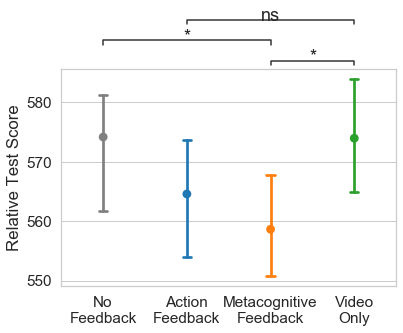

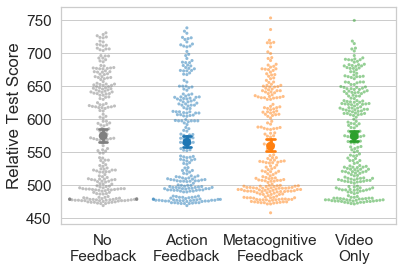

In [22]:
figure(outcome='route_cost')(plot_transfer)
figure(outcome='route_cost', flag='dist')(plot_transfer)

# Backward planning

In [23]:
leaves = {3,4,7,8,11,12}

def stage1_backward(clicks):
    if not clicks:
        return False
    first = clicks[0]
    return first in leaves

stage1['backward'] = stage1.clicks.apply(stage1_backward)

pdf['stage1_backward'] = stage1.groupby('wid').backward.mean()
pdf.groupby('feedback').stage1_backward.mean()

feedback
action    0.265106
meta      0.818884
none      0.271901
video          NaN
Name: stage1_backward, dtype: float64

In [24]:
import networkx as nx

def make_graph(edges):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G

def get_goals(G):
    goal = [k for (k, v) in G.out_degree if v == 0]
    return set(goal)

def click_goal_first(row):
    if not row.reveals:
        return False
    else:
        goals = get_goals(row.graph)
        return row.reveals[0][0] in goals

def ever_goal(row):
    if not row.reveals:
        return False
    else:
        goals = get_goals(row.graph)
        return any(x[0] in goals for x in row.reveals)

def num_goal(row):
    if not row.reveals:
        return 0
    else:
        goals = get_goals(row.graph)
        return sum(x[0] in goals for x in row.reveals)
    
def prop_backward(row):
    if not row.reveals:
        return 0
    else:
        goals = get_goals(row.graph)
        first_clicks = row.reveals[:len(goals)]
        return sum(x[0] in goals for x in first_clicks) / len(first_clicks)

stage2['graph'] = stage2.edges.apply(make_graph)
stage2['backward'] = stage2.apply(click_goal_first, axis=1)
stage2['ever_goal'] = stage2.apply(ever_goal, axis=1)
stage2['num_goal'] = stage2.apply(num_goal, axis=1)
stage2['planned'] = stage2.n_click > 0
stage2['prop_backward'] = stage2.apply(prop_backward, axis=1)

pdf['stage2_backward'] = stage2.groupby('wid').backward.mean()
pdf['stage2_ever_goal'] = stage2.groupby('wid').ever_goal.mean()
pdf['stage2_num_goal'] = stage2.groupby('wid').num_goal.mean()
pdf['stage2_planned'] = stage2.groupby('wid').planned.mean()
pdf['prop_backward'] = stage2.groupby('wid').prop_backward.mean()

pdf['stage2_first_backward'] = stage2.query('trial_index == 0').backward
pdf['stage2_first_ever_goal'] = stage2.query('trial_index == 0').ever_goal
pdf['stage2_first_num_goal'] = stage2.query('trial_index == 0').num_goal

figs/5/learning_curve_backward.pdf


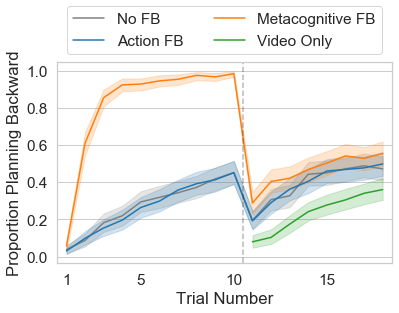

In [25]:
@figure()
def learning_curve_backward():
    plt.figure(figsize=(6, 3.7))
    s2 = stage2.copy()
    s2.trial_index += stage1.trial_index.max() + 1
    df = pd.concat([stage1, s2], sort=False)
    df.trial_index += 1
    sns.lineplot('trial_index', 'backward', hue='feedback', 
                 data=df, hue_order=fb_order, palette=palette)
    plt.xlabel('Trial Number')
    plt.gca().grid(axis='x')
    plt.ylabel('Proportion Planning Backward')
    plt.axvline(10.5, c='k', ls='--', alpha=0.3)
    plt.xticks([1, *range(5, 31, 5)])
    plt.xlim(df.trial_index.min()-0.5, df.trial_index.max()+0.5)
    ax = plt.gca()
#     plt.xlim(0, 19)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=[
        nice_names.get(l, l).replace('\n', ' ').replace("Feedback", "FB") for l in labels[1:]],
#              loc='upper left', bbox_to_anchor=(0, .95))
              ncol=2,
             loc='lower center', bbox_to_anchor=(0.5, 1))

#     plt.legend().remove()
# reformat_legend()
    

In [26]:
rate = 100 * stage2.groupby('feedback').backward.mean()
for c in fb_order:
    r = rate[c]
    write_tex(f'backward-{c}-percent', f"${r:.1f}$\%")

# report_ratio(mdf.query('block == "test"').copy(), 'backward')

wrote "$39.4$\%" to "stats/5/backward-none-percent.tex"
wrote "$39.4$\%" to "stats/5/backward-action-percent.tex"
wrote "$46.3$\%" to "stats/5/backward-meta-percent.tex"
wrote "$23.5$\%" to "stats/5/backward-video-percent.tex"


In [27]:
rdf = pdf[['feedback', 'score', 'route_cost', 'stage2_n_click', 'planning_cost', 'stage2_backward', 
           'stage2_planned', 'bonus', 'prop_backward', 'stage2_num_goal', 'stage2_ever_goal',
           'stage2_first_backward', 'stage2_first_ever_goal', 'stage2_first_num_goal'
          ]]

In [28]:
%%R -i rdf
rdf$feedback = relevel(factor(rdf$feedback), ref="video")

In [29]:
write_kruskal('stage2_backward')
for fb in ['none', 'action', 'video']:
    write_independence_test('stage2_backward', 'meta', fb)
    
for fb in ['none', 'action']:
    write_independence_test('stage2_backward', fb, 'video')

wrote "$H = 37.00, p < .001$" to "stats/5/stage2_backward-kruskal.tex"
wrote "$d = 0.17, Z = 1.82, p = .035$" to "stats/5/independence-stage2_backward-meta-none.tex"
wrote "$d = 0.17, Z = 1.81, p = .035$" to "stats/5/independence-stage2_backward-meta-action.tex"
wrote "$d = 0.61, Z = 6.45, p < .001$" to "stats/5/independence-stage2_backward-meta-video.tex"
wrote "$d = 0.44, Z = 4.75, p < .001$" to "stats/5/independence-stage2_backward-none-video.tex"
wrote "$d = 0.44, Z = 4.76, p < .001$" to "stats/5/independence-stage2_backward-action-video.tex"


In [30]:
write_kruskal('stage2_ever_goal')
for fb in ['none', 'action', 'video']:
    write_independence_test('stage2_ever_goal', 'meta', fb)
    
for fb in ['none', 'action']:
    write_independence_test('stage2_ever_goal', fb, 'video')

wrote "$H = 4.26, p = .235$" to "stats/5/stage2_ever_goal-kruskal.tex"
wrote "$d = 0.14, Z = 1.57, p = .059$" to "stats/5/independence-stage2_ever_goal-meta-none.tex"
wrote "$d = 0.06, Z = 0.61, p = .271$" to "stats/5/independence-stage2_ever_goal-meta-action.tex"
wrote "$d = 0.17, Z = 1.83, p = .033$" to "stats/5/independence-stage2_ever_goal-meta-video.tex"
wrote "$d = 0.02, Z = 0.23, p = .410$" to "stats/5/independence-stage2_ever_goal-none-video.tex"
wrote "$d = 0.11, Z = 1.21, p = .112$" to "stats/5/independence-stage2_ever_goal-action-video.tex"


In [31]:
k = 'backward'
for fb in ['none', 'action', 'video']:
    write_independence_test(f'stage2_{k}', 'meta', fb)

print()
k = 'ever_goal'
for fb in ['none', 'action', 'video']:
    write_independence_test(f'stage2_{k}', 'meta', fb)
    
# for fb in ['none', 'action']:
#     write_independence_test(f'stage2_{k}', fb, 'video')

wrote "$d = 0.17, Z = 1.82, p = .035$" to "stats/5/independence-stage2_backward-meta-none.tex"
wrote "$d = 0.17, Z = 1.81, p = .035$" to "stats/5/independence-stage2_backward-meta-action.tex"
wrote "$d = 0.61, Z = 6.45, p < .001$" to "stats/5/independence-stage2_backward-meta-video.tex"

wrote "$d = 0.14, Z = 1.57, p = .059$" to "stats/5/independence-stage2_ever_goal-meta-none.tex"
wrote "$d = 0.06, Z = 0.61, p = .271$" to "stats/5/independence-stage2_ever_goal-meta-action.tex"
wrote "$d = 0.17, Z = 1.83, p = .033$" to "stats/5/independence-stage2_ever_goal-meta-video.tex"


## Mediation

In [32]:
rdf = stage2.copy()
rdf['feedback'] = pdf.feedback

In [33]:
factors = ['action', 'meta', 'none']
fb = rdf.pop('feedback')
for c in factors:
    rdf[c] = (fb == c).astype(int)

rdf = rdf[[*factors, 'backward', 'score']].reset_index()
rdf.backward.fillna(0, inplace=True)
rdf = rdf.groupby('wid').mean()

In [34]:
%%R -i rdf -o score
fit = lm(score ~ backward, data=rdf)
score = summary(fit)
score


Call:
lm(formula = score ~ backward, data = rdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-76.773 -15.635  -0.574  13.379  86.360 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   15.516      1.222   12.70   <2e-16 ***
backward      84.604      2.257   37.48   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.78 on 961 degrees of freedom
Multiple R-squared:  0.5938,	Adjusted R-squared:  0.5934 
F-statistic:  1405 on 1 and 961 DF,  p-value: < 2.2e-16



In [35]:
score = dict(score.items())
df = score['df'][1]
est, std, t, p = score['coefficients'][1]
write_tex(f'score-backward', f'${est:.1f}$')
write_tex(f'score-backward-test', f'$t({df}) = {t:.2f}$, ${pval(p)}$')

wrote "$84.6$" to "stats/5/score-backward.tex"
wrote "$t(961) = 37.48$, $p < .001$" to "stats/5/score-backward-test.tex"


In [36]:
# %%R
# local({r <- getOption("repos")
#        r["CRAN"] <- "https://cloud.r-project.org" 
#        options(repos=r)
# })
# install.packages('mediation')

In [37]:
%%R -i rdf -o back -o med_out
library(mediation)

if ('action' %in% colnames(rdf)) {
    back_fit = lm(backward ~ action + meta, data=rdf)
    score_fit = lm(score ~ backward + action + meta, data=rdf)
# } else if (EXPERIMENT == 6) {
#     back_fit = lm(backward ~ info + reward, data=rdf)
#     score_fit = lm(score ~ backward + info + reward)
} else {
    back_fit = lm(backward ~ meta, data=rdf)
    score_fit = lm(score ~ backward + meta, data=rdf)
}
med_out = mediate(back_fit, score_fit, treat="meta", mediator="backward")
back = summary(back_fit)
summary(med_out)

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching package: ‘MASS’


R[write to console]: The following object is masked from ‘package:dplyr’:

    select


R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: sandwich

R[write to console]: mediation: Causal Mediation Analysis
Version: 4.5.0





Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME             12.873        7.551        18.10  <2e-16 ***
ADE              -3.841       -7.979         0.37   0.082 .  
Total Effect      9.032        2.580        15.52   0.012 *  
Prop. Mediated    1.424        0.948         3.17   0.012 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 963 


Simulations: 1000 



In [38]:
# back = dict(back.items())
# df = back['df'][1]
# for i, name in enumerate(fb_order[1:], start=1):
#     est, std, t, p = back['coefficients'][i]
#     write_tex(f'backward-lm-{name}', f'$t({df}) = {t:.3f}$, ${pval(p)}$')

In [39]:
names = {
    'acme': 'd0',
    'ade': 'z0',
    'total': 'tau',
    'prop': 'n0',
}
med = dict(med_out.items())

for k, v in names.items():
    est = med[v + ('.coef' if v == 'tau' else '')][0]
    lo, hi = med[v+'.ci']
    p = med[v+'.p'][0]
    write_tex(f'mediation-{k}', f'{est:.1f}')
    write_tex(f'mediation-{k}-ci', f'95\% CI: [{lo:.1f}, {hi:.1f}], ${pval(p)}$')

wrote "12.9" to "stats/5/mediation-acme.tex"
wrote "95\% CI: [7.6, 18.1], $p < .001$" to "stats/5/mediation-acme-ci.tex"
wrote "-3.8" to "stats/5/mediation-ade.tex"
wrote "95\% CI: [-8.0, 0.4], $p = .082$" to "stats/5/mediation-ade-ci.tex"
wrote "9.0" to "stats/5/mediation-total.tex"
wrote "95\% CI: [2.6, 15.5], $p = .012$" to "stats/5/mediation-total-ci.tex"
wrote "1.4" to "stats/5/mediation-prop.tex"
wrote "95\% CI: [0.9, 3.2], $p = .012$" to "stats/5/mediation-prop-ci.tex"


In [40]:
print("Success!")

Success!
